In [2]:
from config import Config
from model.pytorch_models.cnn import CNN
from model.pytorch_models.cvt import ConvolutionalVisionTransformer, QuickGELU, LayerNorm
from model.pytorch_models.rvt import ResidualVisionTransformer, DeepFEC_v2_vehicle_config_model, DeepFEC_v2_vehicle_config_model_2
from __init__ import get_train_test_data
import torch
from torch import nn
from torchsummary import summary
import numpy as np
from functools import partial
from model.metrics import rmse, mape, mae, get_model_save_path
import tensorwatch as tw
import os
import matplotlib.pyplot as plt 

In [3]:
torch.manual_seed(50)

conf = Config("config_fig.yaml")
print(conf.observe_length)

12


In [4]:
# PREPARE DATA
data, arm_shape, train_xs, train_ys, train_arms, train_xp, train_xt, train_xe,\
    train_vehicle_type, train_engine_config, train_gen_weight,\
    test_xs, test_ys, test_arms, test_xp, test_xt, test_xe,\
    test_vehicle_type, test_engine_config, test_gen_weight = \
    get_train_test_data(conf, need_road_network_structure_matrix=True)  # \
print('************** Train - Predict **********')
print('train_xs:', train_xs.shape,  'test_xs:', test_xs.shape, 'train_xp:', train_xp.shape, 'test_xp:',
      test_xp.shape, 'test_xe:', test_xe.shape, 'train_ys:', train_ys.shape, 'test_ys:', test_ys.shape)
print(train_vehicle_type.shape, train_engine_config.shape, train_gen_weight.shape)


complete start
Start load_raw_link_speed_by_road_in_time ing..
speed items 363996
load from raw finish
function load_raw_link_speed_by_road cost 0.4984750747680664 s
preprocess finish
function load_raw_link_speed_by_road_in_time cost 0.4984750747680664 s
complete finish
STM  SHAPE(edges, timeslots)  13*28=  #######  (955, 364)
ARM  SHAPE(edges, A) ####### (955, 5)
T  SHAPE ####### 364
function completion_data cost 1.2372920513153076 s
****************** External Information ****************************
holiday shape (364, 1)
vec shape (day of week 7, weekend/weekday 1, hour of day 13 (364, 21)
External data shape (364, 22)
*********************************************************************
YS shape(,edges,predict_length) (364, 955, 1)
externel_data weather and holidays E.shape(,predict_length,) (364, 1, 22)
****************** Periodicity  Information ****************************
In-day periodicity XC.shape(nb_days,edges,timeslots_in_day) (28, 955, 12, 2)
Weekly periodicity XP.shape(4

In [5]:
if conf.use_vehicle_info:
    train_xs = np.concatenate((train_xs, train_vehicle_type, train_engine_config, train_gen_weight), axis = 3)
    test_xs = np.concatenate((test_xs, test_vehicle_type, test_engine_config, test_gen_weight), axis = 3)

## USE HOLIDAY INFO (train_xe)
# Repeat the last part along axis=1 to match a shape of (23, 955, 22)
train_xe = np.tile(train_xe[:, -1:], (1, 955, 1))
test_xe = np.tile(test_xe[:, -1:], (1, 955, 1))


In [6]:
model = None
if conf.model_name == 'CVT':
    model = ConvolutionalVisionTransformer(
        in_chans=1,
        num_classes=1,
        act_layer=QuickGELU,
        norm_layer=partial(LayerNorm, eps=1e-5),
        spec=conf.cvt_spec
    )
else:
    print("using DeepFEC_v2_vehicle_config_model")
    model = DeepFEC_v2_vehicle_config_model_2(
        in_chans=1,
        num_classes=1,
        act_layer=QuickGELU,
        norm_layer=partial(LayerNorm, eps=1e-5),
        spec=conf.cvt_spec
    )

using DeepFEC_v2_vehicle_config_model


In [7]:

# Define hyperparameters
n_epochs = conf.epochs
lr=0.01

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [8]:
# summary(model, (12, 5, 1), 955)
# Define lists to store training and validation losses
train_losses = []
val_losses = []

In [9]:

## TRAIN
for epoch in range(n_epochs + 1):  # loop over the dataset multiple times
    count = 0
    losses_t = []
    
    for i in range(train_xs.shape[0]):
        # get the inputs; data is a list of [inputs, labels]
        inputs = torch.from_numpy(train_xs[i]).float()
        holiday_inputs = torch.from_numpy(train_xe[i]).float()
        values = torch.from_numpy(train_ys[i]).float()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # print("input :" , inputs.shape)
        outputs = model(inputs, holiday_inputs)

        loss = criterion(outputs, values)
        losses_t.append(loss.item())
        count += 1
        loss.backward()
        optimizer.step()

        # print statistics
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.8f}".format(loss.item()))
        
    sum = 0
    for loss in losses_t:
        sum = sum + loss
    loss_per_epoch = sum / count
    train_losses.append(loss_per_epoch)
    
    losses_v = []
    sum = 0
    count = 0
    for j in range(test_xs.shape[0]):
        t_inputs = torch.from_numpy(test_xs[j]).float()
        h_inputs = torch.from_numpy(test_xe[j]).float()
        t_values = torch.from_numpy(test_ys[j]).float()
        predicted = model(t_inputs, h_inputs)
        loss = criterion(predicted, t_values)
        losses_v.append(loss.item())
        count += 1

    for loss in losses_v:
        sum = sum + loss
    loss_per_epoch = sum / count
    val_losses.append(loss_per_epoch)
        
print('Finished Training, starting testing')


Epoch: 0/40............. Loss: 1.83422315
Epoch: 0/40............. Loss: 0.63252908
Epoch: 0/40............. Loss: 0.17864433
Epoch: 0/40............. Loss: 0.31553894
Epoch: 0/40............. Loss: 0.32970664
Epoch: 0/40............. Loss: 0.54927063
Epoch: 0/40............. Loss: 0.27421477
Epoch: 0/40............. Loss: 0.08178413
Epoch: 0/40............. Loss: 0.06144992
Epoch: 0/40............. Loss: 0.11840423
Epoch: 0/40............. Loss: 0.17213812
Epoch: 0/40............. Loss: 0.18194583
Epoch: 0/40............. Loss: 0.13945504
Epoch: 0/40............. Loss: 0.09736589
Epoch: 0/40............. Loss: 0.04207518
Epoch: 0/40............. Loss: 0.02010020
Epoch: 0/40............. Loss: 0.03874356
Epoch: 0/40............. Loss: 0.06695830
Epoch: 0/40............. Loss: 0.07810384
Epoch: 0/40............. Loss: 0.06151448
Epoch: 0/40............. Loss: 0.03264413
Epoch: 0/40............. Loss: 0.01347053
Epoch: 0/40............. Loss: 0.01637857
Epoch: 1/40............. Loss: 0.0

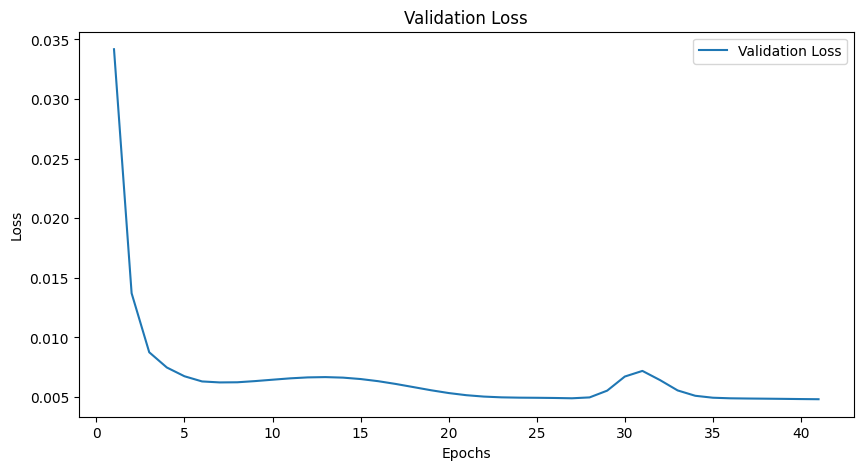

In [10]:
plt.figure(figsize=(10, 5))
# plt.plot(range(1, 41), train_losses[:40], label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()

In [11]:
print(len(train_losses))

41


In [12]:
print(train_xs.shape[0])

23


In [82]:

## Test and calculate accuracy
np_values = np.array([])
np_predicted = np.array([])
t_map = {}
errs = []
with torch.no_grad():
    day_count = 1
    for j in range(test_xs.shape[0]):
        t_inputs = torch.from_numpy(test_xs[j]).float()
        h_inputs = torch.from_numpy(test_xe[j]).float()
        t_values = torch.from_numpy(test_ys[j]).float()
        predicted = model(t_inputs, h_inputs)
        indexes = []
        for i in range(0, 955):
            v_id = t_inputs[i][0][2].item()
            if v_id == 0.0:
                indexes.append(i)
            # if v_id in t_map:
            #     t_map[v_id] += 1
            # else:
            #     t_map[v_id] = 1
        # if (t_inputs[50][0][2].item() == 2.0)
        t_values = t_values.numpy()
        predicted = predicted.numpy()
        for j in range(0, 955):
            if j in indexes:
                np_values = np.append(np_values, t_values[j])
                np_predicted = np.append(np_predicted, predicted[j])
        predict = data.min_max_scala.inverse_transform(np_predicted)
        y_true = data.min_max_scala.inverse_transform(np_values)
        errs.append(rmse(predict, y_true))
        day_count += 1
# predict = data.min_max_scala.inverse_transform(np_predicted)
# y_true = data.min_max_scala.inverse_transform(np_values)
# predict = np_predicted
# y_true = np_values

# v_rmse = rmse(predict, y_true)
# v_mae = mae(predict, y_true)
# v_mape = mape(predict, y_true)

# print("RMSE:", v_rmse)
# print("MAE:", v_mae)
# print("MAPE:", v_mape)

In [83]:
errs

[0.5654200041066804,
 0.5654200041066804,
 0.5654200041066804,
 0.5654200041066804,
 0.5654200041066804]

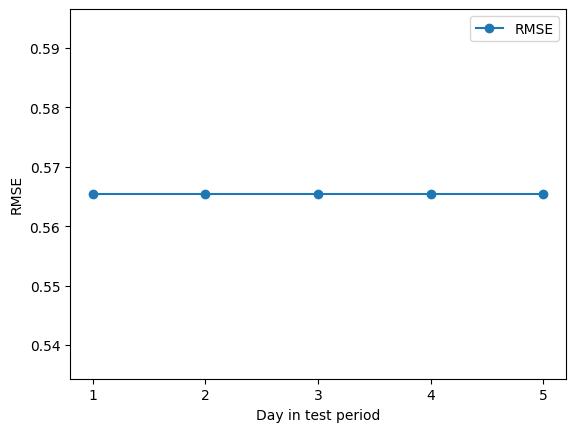

In [84]:
# Plotting rmse
plt.plot(errs, label='RMSE', marker='o')

# Adding labels and title
plt.xlabel('Day in test period')
plt.ylabel('RMSE')
# Setting specific x-axis labels
x_labels = [0, 1, 2, 3, 4]
plt.xticks(x_labels, [str(label + 1) for label in x_labels])
# plt.title('Real vs Predicted Values')
# Displaying the legend to identify real and predicted values
plt.legend()
# Showing the plot
plt.show()

In [81]:
predict

array([0.37545535, 0.37545535, 0.37545535, 0.37545535, 0.37545535,
       0.37545535, 0.37545535, 0.37545535, 0.37545535, 0.37545535,
       0.37545535, 0.37545535, 0.71619827, 0.39805605, 1.35189462,
       1.35189462, 1.35189462, 1.35189462, 1.35189462, 1.35189462,
       1.35189462, 1.35189462, 1.35189462, 1.35189462, 1.35189534,
       1.35189534, 1.35189534, 1.35189462, 1.35189462, 1.35189462,
       1.35189462, 1.35189462, 0.75278758, 0.37438964, 0.37438964,
       0.37438964, 0.37438964, 0.37438964, 0.37438964, 0.37438964,
       0.37438964, 0.37438964, 0.37438964, 0.37438964, 0.37438964,
       0.37438964, 0.37438964, 0.37438964, 0.37438964, 0.37438964,
       0.37438964, 0.37438964, 0.37438964, 0.37438964, 0.37438964,
       0.37438964, 0.37438964, 0.37438964, 0.37438964, 0.37438964,
       0.37438964, 0.37438964, 1.23454613, 0.61589736, 0.61520677,
       0.61589882, 1.95288953, 3.4563631 , 3.4563631 , 0.61450963,
       0.61546629, 0.61546629, 0.61546629, 0.95552661, 1.22617

In [57]:
real_predict_list = []
for i in range(0, 955, 50):
    real_predict_list.append((y_true[i],predict[i]))

In [58]:
real_predict_list

[(0.8957096130968951, 0.54306114923153),
 (0.5280704609293814, 0.5608349449780832),
 (0.3557980365239928, 0.7514361873407598),
 (0.3982817700259229, 0.4489901548602244),
 (2.021983799960857, 2.0555966283709592),
 (2.021983799960857, 2.0555966283709592),
 (2.021983799960857, 2.0555966283709592),
 (0.6186161374081349, 0.7137273895182261),
 (0.4145424305640315, 0.5429811853242859),
 (0.4145424305640315, 0.5429811853242859),
 (0.8957096130968951, 0.5430073553302934),
 (0.5280704609293814, 0.5607884205229592),
 (0.8132275697191087, 0.5432225309352408),
 (0.3982817700259229, 0.44894072262665485),
 (2.021983799960857, 2.05556391586345),
 (2.021983799960857, 2.05556391586345),
 (2.021983799960857, 2.05556391586345),
 (0.4145424305640315, 0.5429237566999925),
 (0.4145424305640315, 0.5429237566999925),
 (0.4145424305640315, 0.5429237566999925)]

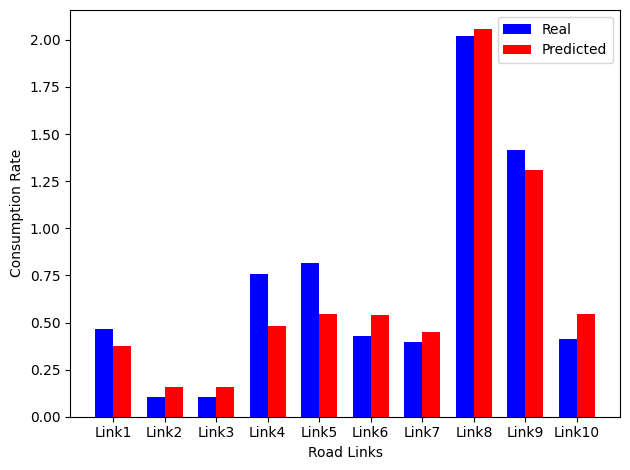

In [17]:
# Separate the real and predicted values
# 

# Create the bar positions
bar_width = 0.35
index = np.arange(len(real_values))

# Create the bar graph
fig, ax = plt.subplots()
bar1 = ax.bar(index, real_values, bar_width, label='Real', color='b')
bar2 = ax.bar(index + bar_width, predicted_values, bar_width, label='Predicted', color='r')

# Set the labels, title, and legend
ax.set_xlabel('Road Links')
ax.set_ylabel('Consumption Rate')
# ax.set_title('Comparison between Real and Predicted Values')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(['Link' + str(i) for i in range(1, len(real_values) + 1)])
ax.legend()

# Show the bar graph
plt.tight_layout()
plt.show()

In [18]:
test_vehicle_type.shape

(5, 955, 12, 1)

In [19]:
vehicle_types = np.apply_along_axis(lambda x: ''.join(map(str, x)), axis=2, arr=test_vehicle_type)

In [20]:
vehicle_types.shape

(5, 955, 1)

In [32]:
vehicle_types[1][954]

array(['222222222222'], dtype='<U12')

In [33]:
k_map = {}
for i in range(0,4):
    for j in range(0,955):
        if vehicle_types[i][j][0] in k_map:
            k_map[vehicle_types[i][j][0]] += 1
        else:
            k_map[vehicle_types[i][j][0]] = 1

k_map
            

{'111111111111': 514,
 '111111212224': 1,
 '222222222222': 1923,
 '111111111444': 1,
 '444444444444': 1189,
 '222111111111': 1,
 '111112212224': 1,
 '111111222412': 1,
 '444422212442': 1,
 '000000000411': 2,
 '222222222444': 6,
 '111111111411': 4,
 '111122222222': 17,
 '222222244444': 1,
 '111111122222': 10,
 '222212242222': 1,
 '222211422222': 1,
 '222221144221': 1,
 '222212422112': 1,
 '444422212424': 1,
 '111111122411': 1,
 '111111122422': 1,
 '222112422112': 1,
 '222221222211': 2,
 '111112422211': 1,
 '222222222244': 2,
 '000022222442': 1,
 '000000000442': 1,
 '000022222242': 1,
 '111111111114': 3,
 '222222222224': 2,
 '111111112222': 2,
 '444422212111': 1,
 '444422212444': 1,
 '444422212114': 1,
 '222212411121': 1,
 '222212444121': 1,
 '222212444124': 1,
 '222212444111': 1,
 '111111111414': 1,
 '222222222414': 1,
 '000000000044': 1,
 '111111222411': 1,
 '222222242214': 1,
 '111111112224': 2,
 '111111112214': 1,
 '111112212214': 1,
 '444444222222': 6,
 '111111222222': 6,
 '44444442